In [2]:
# Q2 METHOD
import geopandas as gpd
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from geopandas import GeoDataFrame

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
vaccine_df = pd.read_csv('https://covid.ourworldindata.org/data/owid-covid-data.csv?v=2021-02-17').fillna(0)

# Filter for columns relevant to the research project
df = vaccine_df[['iso_code', 'continent', 'location',
                      'date', 'total_cases', 'total_vaccinations',
                      'people_vaccinated', 'people_fully_vaccinated',
                      'new_vaccinations', 'population','gdp_per_capita']]

# Fill in missing iso codes for countries in world data
world.loc[world['name'] == 'Norway', 'iso_a3'] = 'NOR'
world.loc[world['name'] == 'France', 'iso_a3'] = 'FRA'
world.loc[world['name'] == 'N. Cyprus', 'iso_a3'] = 'OWID_NCY'
world.loc[world['name'] == 'Somaliland', 'iso_a3'] = 'SOM'
world.loc[world['name'] == 'Kosovo', 'iso_a3'] = 'OWID_KOS'

In [3]:
# Calculate latest date with vaccine data and get % vaccinated

# Filter only for columns needed to plot map
q2_df = df[['iso_code',
         'continent',
         'location',
         'date',
         'people_vaccinated',
         'total_vaccinations',
         'population']]

# Removing days that portray total vaccinations as 0 to prevent illogical data spikes
# Some countries that have not yet started issuing vaccines will also
# be removed from this analysis
q2_df = q2_df[q2_df['total_vaccinations'] != 0]

# Create blank dataframe to store latest dates that contain relevant data
latest_data = pd.DataFrame(columns=q2_df.columns)

# Get a list of all country iso codes
countries = q2_df['iso_code'].unique()

for country in countries:
    new_country = q2_df[q2_df['iso_code'] == country]
    # Latest data for that country
    recent_day = new_country.iloc[[-1]].copy()
    # Replace people vaccinated data with total vaccinated if missing
    if (recent_day['people_vaccinated'] == 0).any():
        recent_day['people_vaccinated'] = recent_day['total_vaccinations']
    # Calculate percent vaccinated for country
    recent_day['percent_vaccinated'] = \
        (recent_day['people_vaccinated'] / recent_day['population']) * 100
    # Add data to dataframe
    latest_data = latest_data.append(recent_day)

# Remove irrelevant data
latest_data = latest_data[latest_data['location'] != 'World']

In [5]:
# Combining world geopanda dataset with vaccine dataset's latest data
merged_df = latest_data.merge(world, left_on='iso_code', right_on='iso_a3', how='left')
merged_df = GeoDataFrame(merged_df)

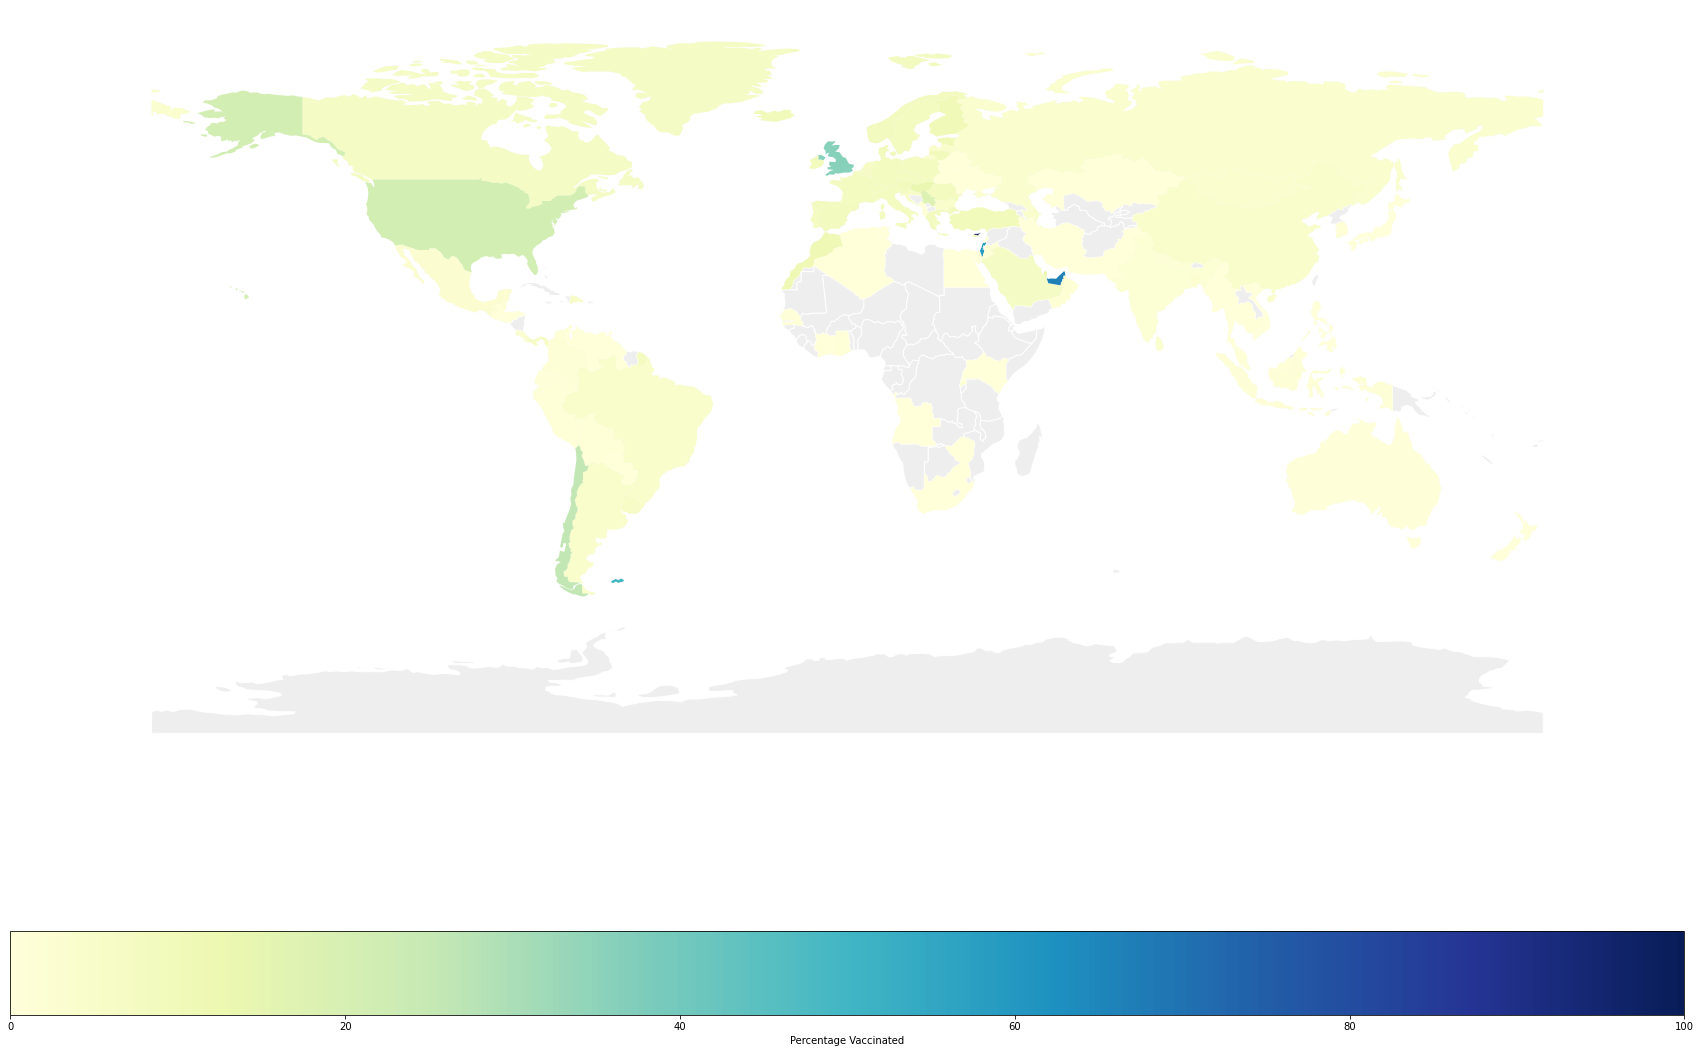

In [7]:
# Plotting the map for world vaccination rate
fig, ax = plt.subplots(1, figsize=(30,20))
ax.axis('off')
world.plot(ax=ax, color='#EEEEEE', edgecolor='#FFFFFF', missing_kwds={'color': 'lightgrey'})
merged_df.plot(ax=ax,
               column='percent_vaccinated',
               legend=True, vmin=0, vmax=100,
               legend_kwds={'label': 'Percentage Vaccinated',
                            'orientation': 'horizontal'})
fig.savefig('q2_map.png')